In [1]:
# Install lap, required for SFSORT
!pip install lap -q

#Install ultralytics to access the object detector
!pip install ultralytics -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Import essential libraries
import numpy as np
import cv2
from PIL import Image

from ultralytics import YOLO
from ultralytics.utils.torch_utils import select_device
from random import randrange

from SFSORT import SFSORT

In [9]:
# Instantiate an object detector
model = YOLO('yolov8m.pt')

# Check for GPU availability
device = select_device('cpu')
# Devolve the processing to selected devices
model.to(device)

Ultralytics YOLOv8.2.27 🚀 Python-3.9.2 torch-2.3.0+cpu CPU (11th Gen Intel Core(TM) i5-11400H 2.70GHz)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_

In [4]:
# Load the video file
cap = cv2.VideoCapture('tst1.mov')

In [5]:
# Get the frame rate, frame width, and frame height
frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [6]:
# Define the MP4 codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_1.mp4', fourcc, 30.0, (frame_width, frame_height))

# Organize tracker arguments into standard format
tracker_arguments = {"dynamic_tuning": True, "cth": 0.2,
                      "high_th": 0.82, "high_th_m": 0.1,
                      "match_th_first": 0.5, "match_th_first_m": 0.05,
                      "match_th_second": 0.1, "low_th": 0.1,
                      "new_track_th": 0.2, "new_track_th_m": 0.1,
                      "marginal_timeout": (7 * frame_rate // 10),
                      "central_timeout": frame_rate,
                      "horizontal_margin": frame_width // 10,
                      "vertical_margin": frame_height // 10,
                      "frame_width": frame_width,
                      "frame_height": frame_height}

# Instantiate a tracker
tracker = SFSORT(tracker_arguments)

# Define a color list for track visualization
colors = {}
frame_count = 0

In [10]:
# Process each frame of the video
while cap.isOpened():
   # Load the frame
  ret, frame = cap.read()
  if not ret:
      break
  print(f"predict frame # {frame_count}/{frame_length}")
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # Detect people in the frame
  prediction = model.predict(frame, imgsz=(736,1280), conf=0.1, iou=0.45,
                              half=False, device=device, max_det=99, classes=2,
                              verbose=False)

  # Exclude additional information from the predictions
  prediction_results = prediction[0].boxes.cpu().numpy()

  # Update the tracker with the latest detections
  tracks = tracker.update(prediction_results.xyxy, prediction_results.conf)

  # Skip additional analysis if the tracker is not currently tracking anyone
  print(f"Prediction results:\n{prediction_results.cls}\n{prediction_results.conf}\nTracks available: {len(tracks)}\n")
  if len(tracks) == 0:
      out.write(frame)
      continue

  # Extract tracking data from the tracker
  bbox_list = tracks[:, 0]
  track_id_list = tracks[:, 1]

  # Visualize tracks
  for idx, (track_id, bbox) in enumerate(zip(track_id_list, bbox_list)):
    # Define a new color for newly detected tracks
    if track_id not in colors:
        colors[track_id] = (randrange(255), randrange(255), randrange(255))

    color = colors[track_id]

    # Extract the bounding box coordinates
    x0, y0, x1, y1 = map(int, bbox)

    # Draw the bounding boxes on the frame
    annotated_frame = cv2.rectangle(frame, (x0, y0), (x1, y1), color, 2)
    # Put the track label on the frame alongside the bounding box
    cv2.putText(annotated_frame, str(track_id), (x0, y0-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


  # Write the frame to the output video file
  out.write(annotated_frame)
  frame_count += 1
# Release everything when done
cap.release()
out.release()

predict frame # 0/1217


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Prediction results:
[          2           2]
[    0.93093     0.71382]
Tracks available: 1

predict frame # 1/1217
Prediction results:
[          2           2]
[    0.92563     0.79652]
Tracks available: 2

predict frame # 2/1217
Prediction results:
[          2           2]
[    0.91049     0.76001]
Tracks available: 2

predict frame # 3/1217
Prediction results:
[          2]
[    0.92244]
Tracks available: 1

predict frame # 4/1217
Prediction results:
[          2           2]
[    0.92904     0.88678]
Tracks available: 2

predict frame # 5/1217
Prediction results:
[          2           2]
[    0.94085     0.91186]
Tracks available: 2

predict frame # 6/1217
Prediction results:
[          2           2]
[    0.94062     0.87969]
Tracks available: 2

predict frame # 7/1217
Prediction results:
[          2           2           2]
[    0.94198     0.91718     0.12857]
Tracks available: 2

predict frame # 8/1217
Prediction results:
[          2           2           2]
[    0.91679  

KeyboardInterrupt: 

In [11]:
cap.release()
out.release()

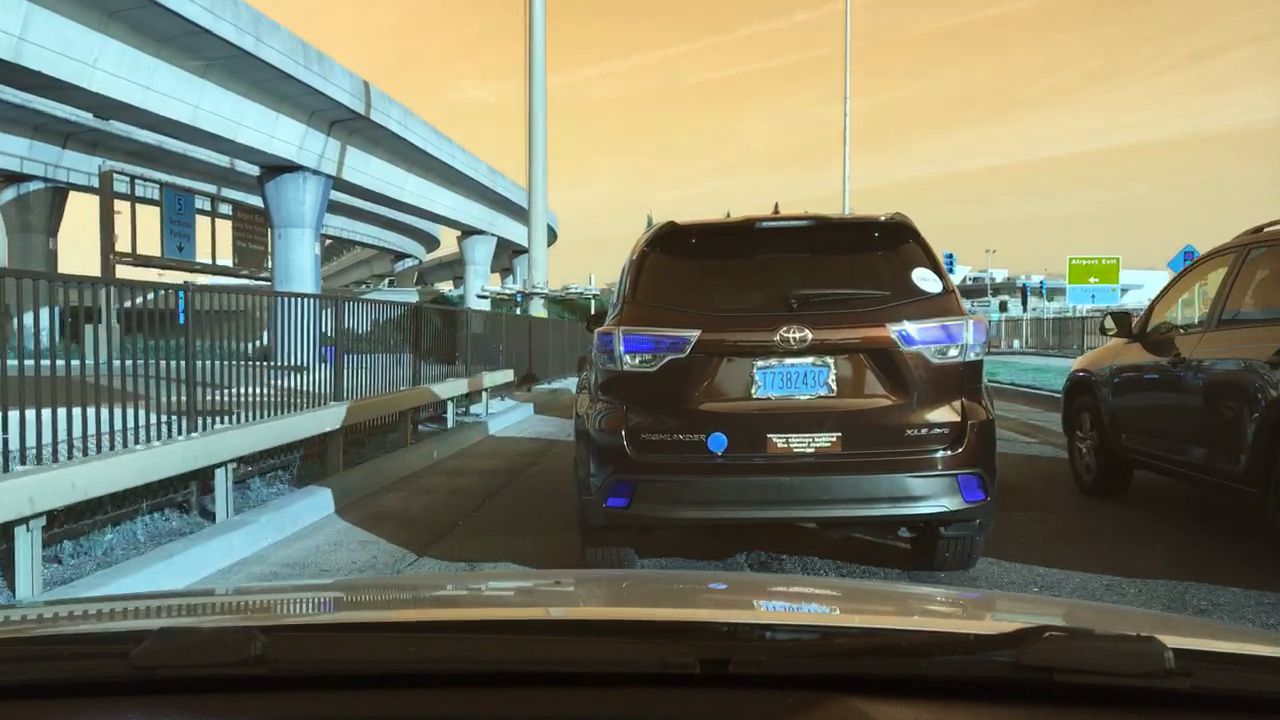

In [12]:
Image.fromarray(frame)

In [ ]:
prediction[0].boxes.cpu().numpy()

ultralytics.engine.results.Boxes object with attributes:

cls: array([          2,           2,           2,           2,           2], dtype=float32)
conf: array([    0.91667,     0.87103,     0.86381,     0.11843,     0.10286], dtype=float32)
data: array([[     697.01,      305.81,      858.99,      427.79,     0.91667,           2],
       [     914.51,      281.22,      1066.2,      417.06,     0.87103,           2],
       [     1006.6,      187.31,      1279.4,      546.94,     0.86381,           2],
       [     831.43,      317.28,      860.63,      381.83,     0.11843,           2],
       [     615.43,      563.01,      1275.5,      634.55,     0.10286,           2]], dtype=float32)
id: None
is_track: False
orig_shape: (720, 1280)
shape: (5, 6)
xywh: array([[        778,       366.8,      161.98,      121.98],
       [     990.38,      349.14,      151.72,      135.84],
       [       1143,      367.13,      272.79,      359.63],
       [     846.03,      349.56,      29.208,